## XマッチのブキごとのXパワー分布

In [6]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 1)
date_to = dt.date(2023, 6, 7)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

バトル数: 5649


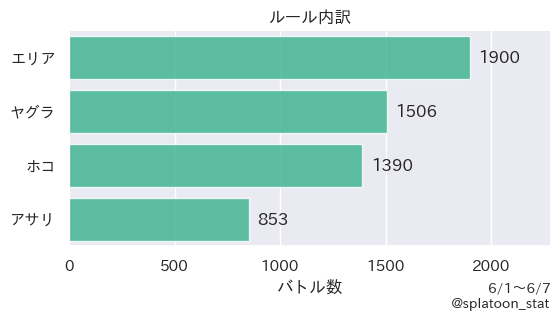

パワー不明バトル数: 1359


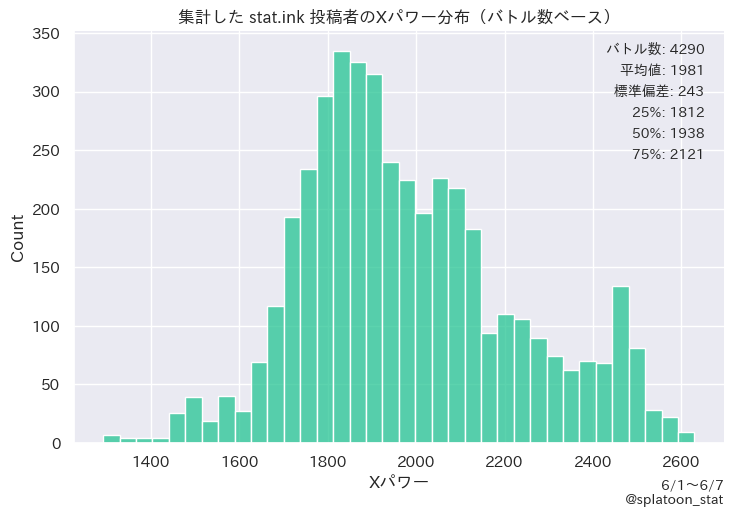

In [7]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

In [8]:
players = u.to_players(battles)

In [9]:
usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame(name="usage")
usage_map = usage.reset_index().pivot(index="weapon", columns="mode", values="usage").reindex(d.MODE_ORDER, axis=1)
usage_map["mean"] = usage_map.mean(axis=1)
usage_map = usage_map.sort_values("mean", ascending=False)
usage_map

mode                      area    yagura      hoko     asari      mean
weapon                                                                
sshooter_collabo      0.050226  0.053880  0.058582  0.056942  0.054907
sshooter              0.032857  0.033390  0.046146  0.040864  0.038314
wakaba                0.039774  0.044489  0.027030  0.041032  0.038081
spaceshooter_collabo  0.043910  0.032916  0.038643  0.036342  0.037953
sharp_neo             0.039098  0.042022  0.028571  0.023112  0.033201
...                        ...       ...       ...       ...       ...
bucketslosher_deco    0.000526  0.000190  0.000617  0.001340  0.000668
l3reelgun             0.000677  0.000474       NaN       NaN  0.000575
wideroller            0.001053  0.000190  0.000617  0.000335  0.000548
h3reelgun             0.000301  0.000949  0.000308  0.000335  0.000473
carbon                0.000301  0.000664  0.000411       NaN  0.000459

[90 rows x 5 columns]

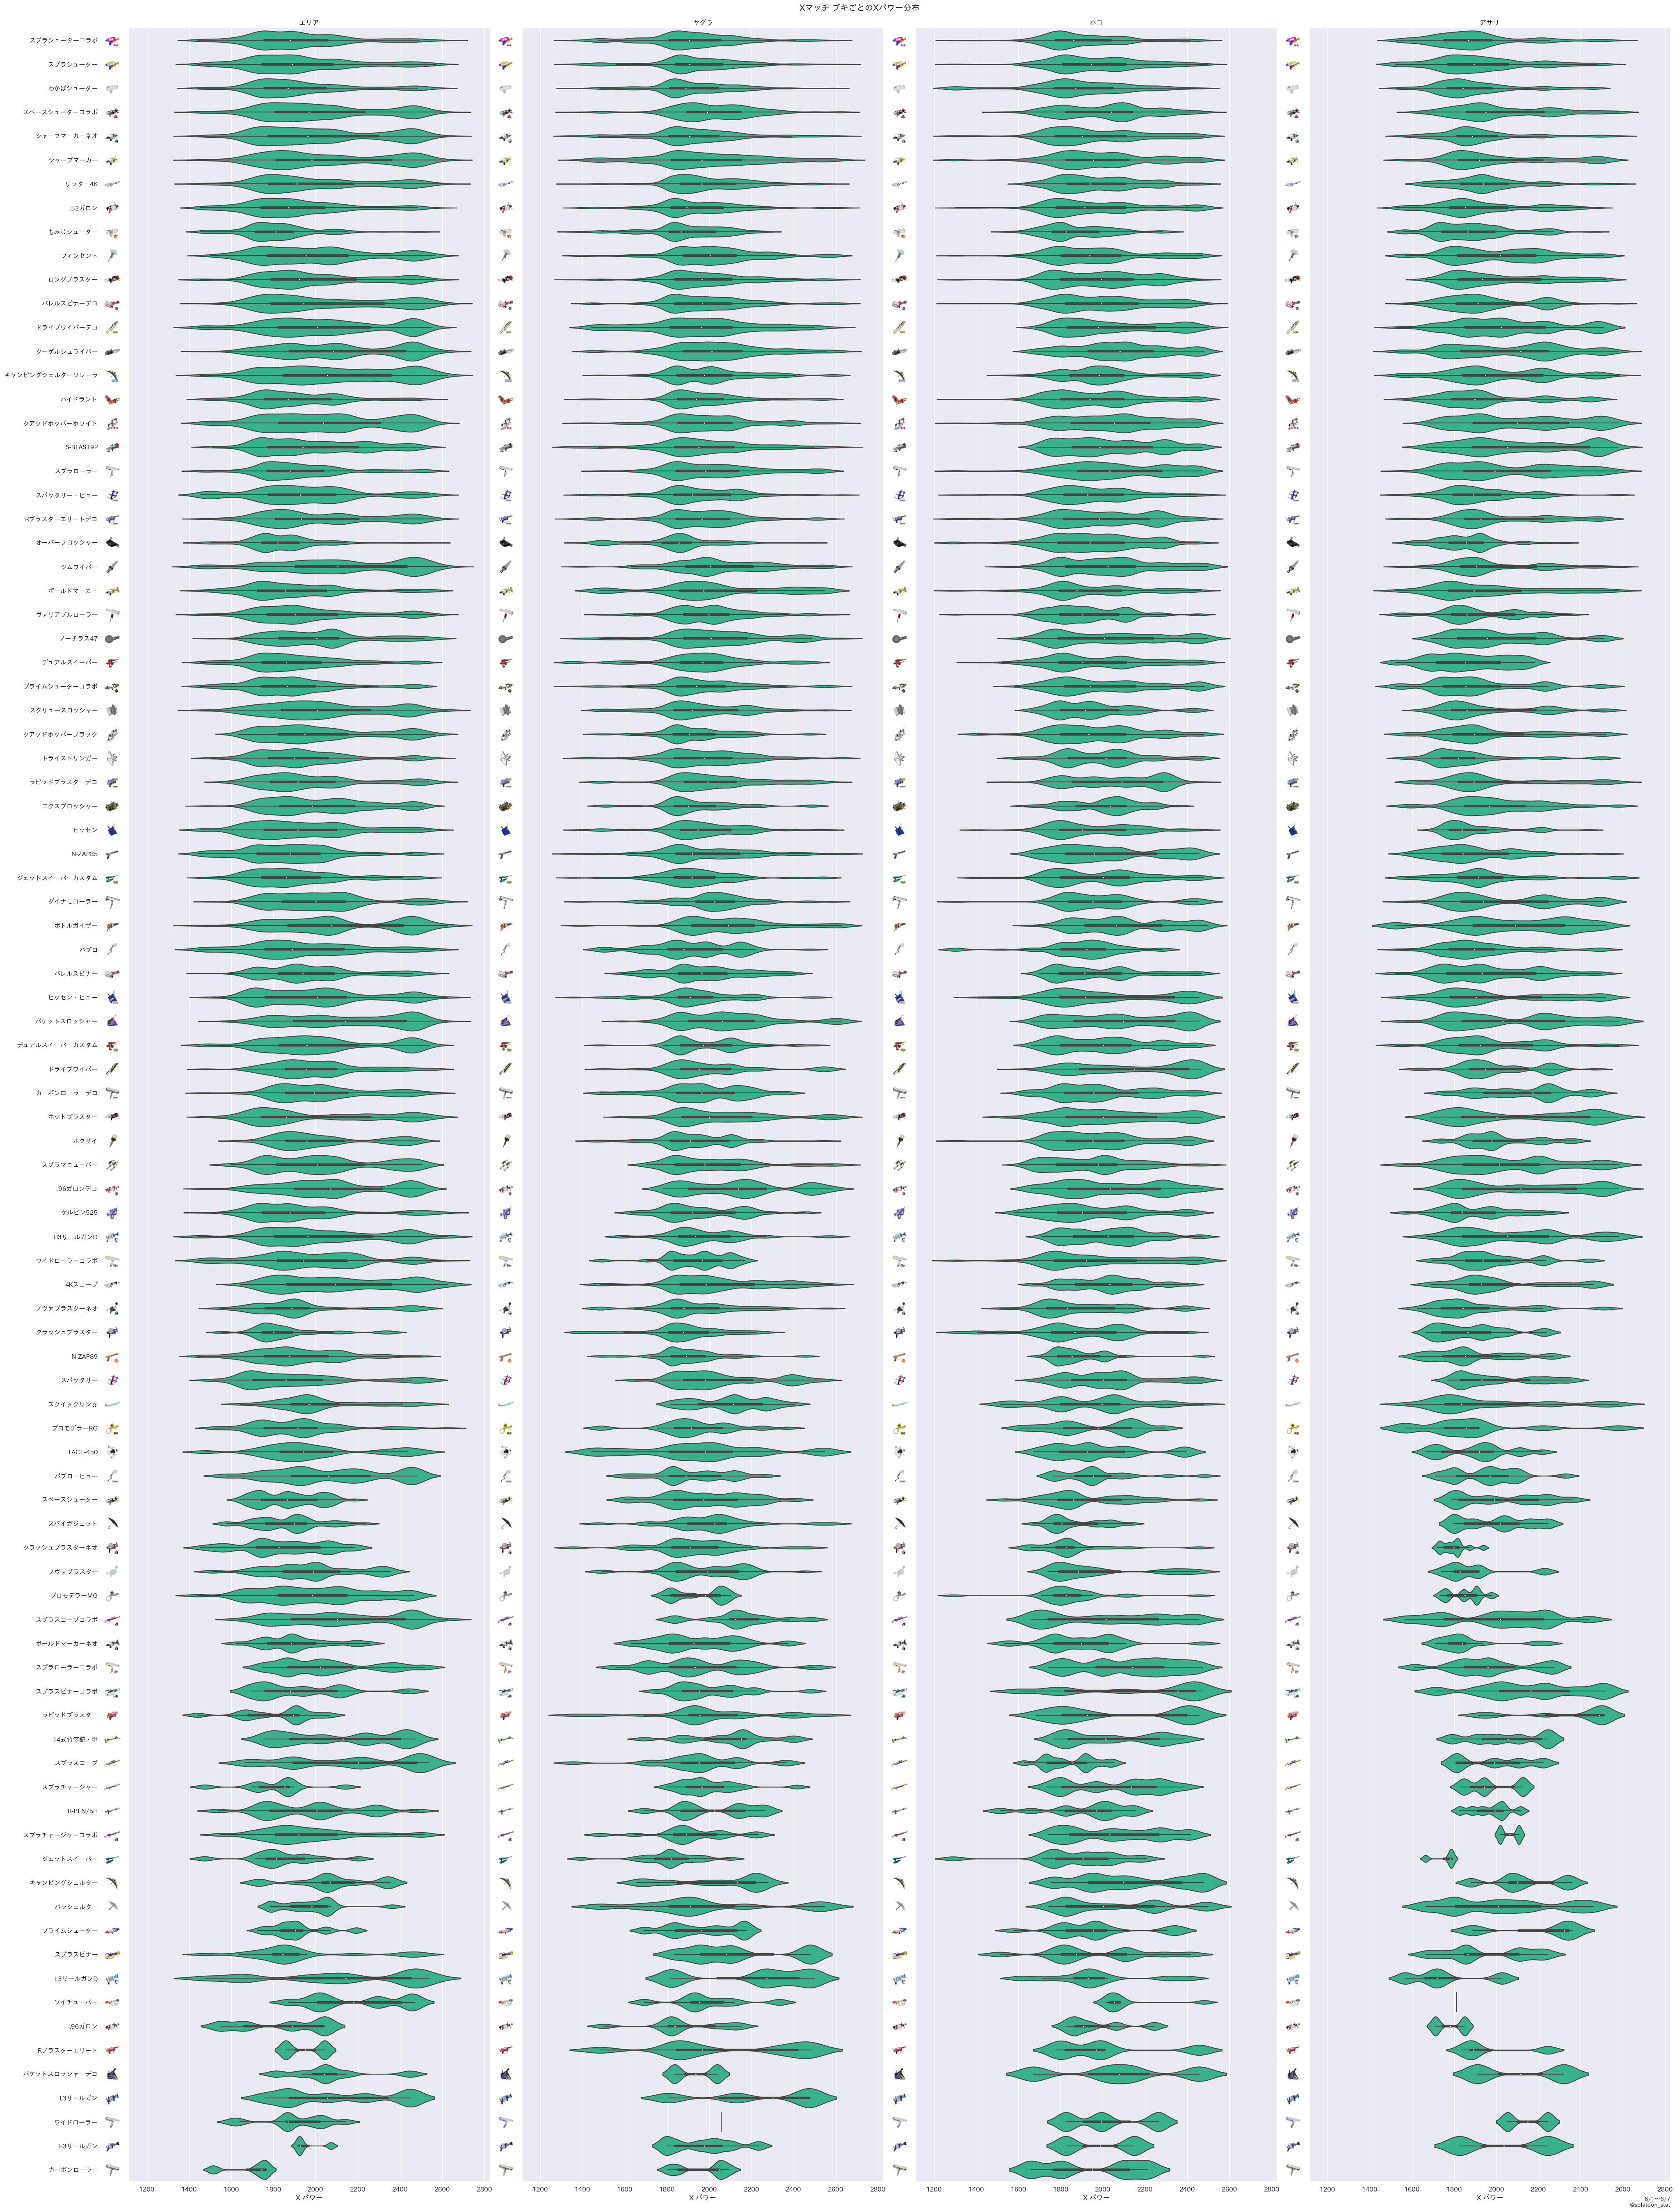

In [10]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("power", "X パワー", "X Power")
i18n.add("title", "${lobby} ブキごとのXパワー分布", "X Power distribution of each weapon in ${lobby} [%]")

width = 10
height = len(usage) * 0.15

g = sns.catplot(
    data=players,
    x="power",
    y="weapon",
    order=usage_map.index,
    col="mode",
    col_order=d.MODE_ORDER,
    kind="violin",
    scale="width",
    bw=.2,
    color=d.Color.XMATCH.value,
    height=height,
    aspect=width/height,
)

yticklabels = [i18n.t(x) for x in usage_map.index]

g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)
g.fig.subplots_adjust(wspace=0.09)

g.set(
    xlabel=i18n.t("power"),
    ylabel="",
)
g.set_yticklabels(yticklabels, x=-0.07)

for i, ax in enumerate(g.axes[0]):
    mode_key = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode_key))

    xmin, xmax = ax.get_xlim()
    image_offset = xmin - (xmax - xmin) * 0.045
    for j, weapon in enumerate(usage_map.index):
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=.8)
        img.image.axes = ax
        ab = AnnotationBbox(img, (2000, 0), xybox=(image_offset, j), frameon=False, pad=0)
        ax.add_artist(ab)

u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()